In [1]:
import numpy as np
import torch
import random

# Fix random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## **1. Prepare the Binary Classification Dataset:**

#### In this step, we load the breast cancer dataset from the Wisconsin repository. The dataset is carefully partitioned into three distinct subsets: **Training**, **Testing**, and **Validation**. The **Training** set contains 341 data points, providing a solid foundation for the model to learn from. Meanwhile, both the **Testing** and **Validation** sets each consist of 114 data points, ensuring a balanced evaluation of the model's performance on previously unseen data. This thoughtful division enables a thorough assessment of the model's generalization capabilities.


In [2]:
from data.breast_data import getBreastData

train, val, test, feature_names = getBreastData()

## **2. Build and Train the Model**

#### Next, we define a basic linear model with custom layer dimensions, incorporating the ReLU activation function. In the code below, we configure two hidden layers with dimensions of 100 and 40 neurons, respectively. The model also features fixed input and output sizes of 30 and 2, ensuring that the architecture is well-suited for the given task.


In [3]:
from model.linear import LinearModel

model = LinearModel(30, 2, [100, 40])
print(model)

LinearModel(
  (layers): ModuleList(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=2, bias=True)
  )
)


### **Training**

#### In this step, we proceed with training our model. We utilize the Adam optimizer along with PyTorch's `cross_entropy` loss function. Optionally, we can also specify the device to ensure efficient computation, especially when leveraging hardware accelerators such as GPUs.


In [4]:
from model.training import train_model

history = train_model(
    model, train, val, "Adam", "cross_entropy", device="cpu", num_epochs=10
)

Epoch 1/10
------------------------------
Train Loss: 0.6265, Train Accuracy: 0.7038
Val Loss: 0.5313, Val Accuracy: 0.9561
Epoch 2/10
------------------------------
Train Loss: 0.4398, Train Accuracy: 0.9443
Val Loss: 0.3397, Val Accuracy: 0.9474
Epoch 3/10
------------------------------
Train Loss: 0.2494, Train Accuracy: 0.9443
Val Loss: 0.1934, Val Accuracy: 0.9474
Epoch 4/10
------------------------------
Train Loss: 0.1404, Train Accuracy: 0.9589
Val Loss: 0.1353, Val Accuracy: 0.9474
Epoch 5/10
------------------------------
Train Loss: 0.1000, Train Accuracy: 0.9736
Val Loss: 0.1067, Val Accuracy: 0.9561
Epoch 6/10
------------------------------
Train Loss: 0.0799, Train Accuracy: 0.9824
Val Loss: 0.0886, Val Accuracy: 0.9474
Epoch 7/10
------------------------------
Train Loss: 0.0675, Train Accuracy: 0.9853
Val Loss: 0.0785, Val Accuracy: 0.9737
Epoch 8/10
------------------------------
Train Loss: 0.0591, Train Accuracy: 0.9883
Val Loss: 0.0724, Val Accuracy: 0.9737
Epoch 9/

C:\Users\Risha\Desktop\XAI\model\training.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = torch.tensor(inputs).to(device), torch.tensor(labels).to(
C:\Users\Risha\Desktop\XAI\model\training.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = torch.tensor(inputs).to(device), torch.tensor(
C:\Users\Risha\Desktop\XAI\model\training.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = torch.tensor(inputs).to(device), torch.tensor(labels).to(
C:\Users\Risha\Desktop\XAI\model\training.py

### **Training Statistics**

#### Upon training, the model returns a history object, which is a dictionary containing key metrics such as `train_loss`, `val_loss`, `train_acc`, `train_f1`, and `val_f1`. Each of these metrics is stored as a list, with values recorded at each epoch, providing a comprehensive view of the model's performance over time.


In [5]:
print(history.keys())

dict_keys(['train_loss', 'val_loss', 'train_acc', 'val_acc', 'train_f1', 'val_f1'])


### **Model Evaluation**

#### In this step, we visualize the performance metrics by plotting them on a graph. The x-axis represents the epochs, while the y-axis corresponds to the metric values. The `plot_accuracy` function takes the history dictionary and generates plots for both the training and validation accuracy, allowing us to easily assess the model's progress over time.


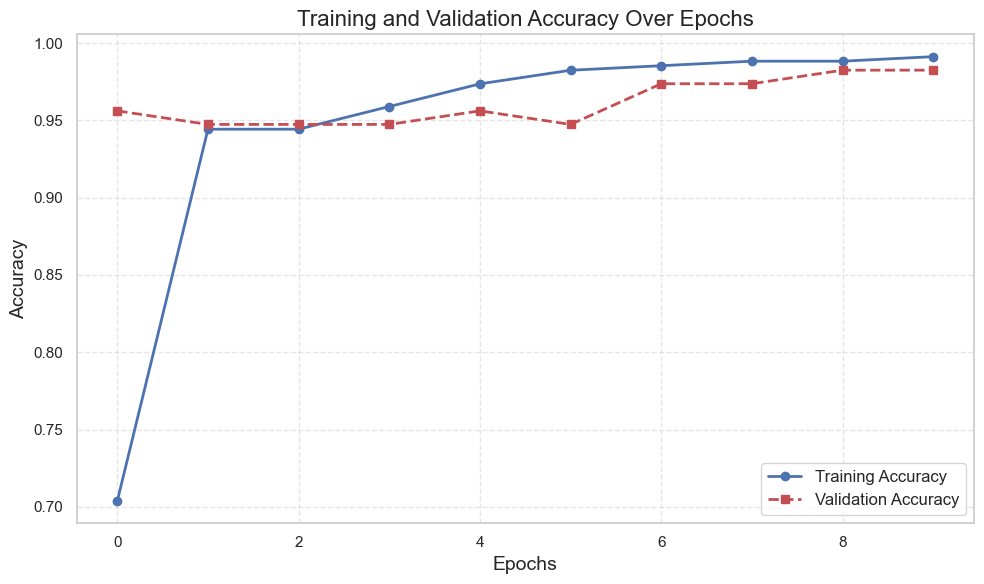

In [6]:
from visualisation.metrics import plot_accuracy

plot_accuracy(history)

**The function `plot_f1_scores` plots the training as well as validation F1 score**

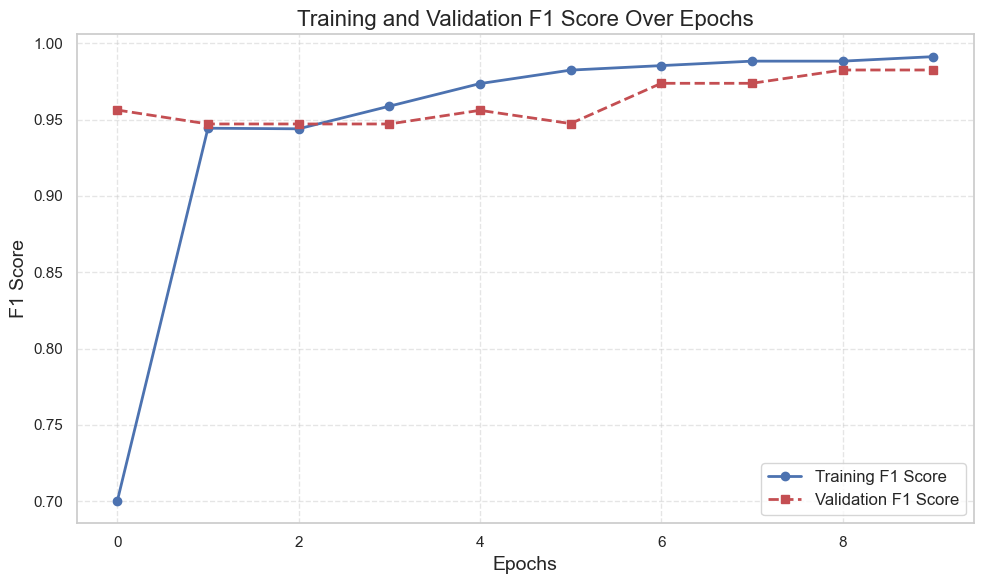

In [7]:
from visualisation.metrics import plot_f1_scores

plot_f1_scores(history)

**The `plot_roc_auc` function takes in input the trained model, and the `X` and `Y` tensors of the test data.**

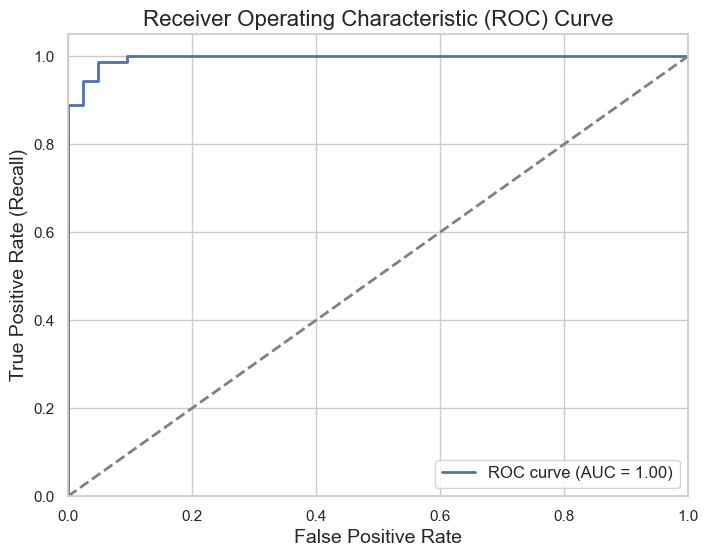

0.9953703703703703

In [8]:
from visualisation.metrics import plot_roc_auc

plot_roc_auc(model, test[0], test[1], device="cpu")

# **3. Generate Explanations Using LIME**

#### The LIME analysis begins here. From this point forward, we leverage the Captum library to gain valuable insights into the inner workings of our model, helping us better understand its decision-making process.


**Separating training as well as true labels.**

In [9]:
test_data, true_labels = test

In [10]:
# Testing model accuracy on our test dataset
# Get model predictions
import torch

predicted_probs = model(test_data).detach()
predicted_labels = torch.argmax(predicted_probs, dim=1)
accuracy = (predicted_labels == test[1]).float().mean().item() * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 94.74%


**Below we sample few data points to perform our analysis on, we take only 4 points, each of different type, FP,TP,FN,TN**

In [11]:
from lime_analysis.utils import get_subset_samples
from lime_analysis.lime_explanations import initialize_lime, generate_explanations

# Get subset of samples, currently four: (FP, TP, FN, TN)
selected_indices = get_subset_samples(test_data, true_labels, model, use_random=True)




*Selected indices is simple a dictionary, which maps the type of sample(FP,TP,TN,TP) to the index of the test dataset.*




In [12]:
selected_indices

{'FP': [35], 'TP': [37], 'FN': [16], 'TN': [49]}

**We need to initialize Lime, which creates an instance of the Lime model, taking as input our trained model**

In [13]:
# Initialize LIME
lime = initialize_lime(model)

### Generate Explanations

The **Generate Explanations** function takes the following inputs:
- The **LIME** instance of the model
- The **test data**
- The **true labels**
- The **indices of the data points** selected for analysis

It returns, for each of the chosen data points:
1. **Feature importance** (scaled using absolute max scaling)
2. The **time** taken to generate the explanation for each data point

***Note***: The code provided below serves as an example to demonstrate the process. In practice, we will invoke this function individually for each data point to generate and visualize their respective explanation curves.


In [14]:
explanations, time = generate_explanations(
    lime,
    test_data,
    true_labels,
    selected_indices,
)
explanations

{'FP': {'indices': [35],
  'attributions': array([-0.30653733,  0.1888637 , -0.16439372, -0.2598358 ,  0.02529837,
          0.02566566,  0.00733746,  0.00716307,  0.        , -0.13161172,
         -0.12304433, -0.04471013, -0.16131419, -0.21940085, -0.10842963,
          0.        ,  0.        ,  0.        ,  0.03269542,  0.03175988,
         -0.33602503,  0.696193  , -0.24730068, -0.28625202,  1.        ,
          0.        ,  0.19579929,  0.10451464,  0.01343503,  0.01924082],
        dtype=float32)},
 'TP': {'indices': [37],
  'attributions': array([ 0.4117224 ,  0.0436034 ,  0.3799439 ,  0.23698857, -0.07305777,
          0.01705796,  0.03540591,  0.        , -0.14075196,  0.        ,
         -0.404185  ,  0.05948193, -0.46100628,  0.        ,  0.16336   ,
          0.        ,  0.        , -0.2972366 ,  0.        , -0.1201949 ,
          0.73531765,  0.7532903 ,  0.28703013,  0.48778135,  0.        ,
          0.05287123,  0.50145316,  0.        ,  1.        ,  0.        ],
   

In [15]:
AUPC_dict = (
    {}
)  # a dictionary to store the Area Under the Perturbation Curve, so as to compare later

# **Visualizing Feature Importance**

Having explored the explanations (also known as attributions), we now focus on visualizing the importance of each feature through a plot.

The detailed analyses and corresponding plots/visualizations for each sample are covered separately.

***NOTE: Initially, I implemented a loop to automatically generate all the plots for each sample. However, I realized that the large number of plots became difficult to manage for a single instance. Therefore, I opted to split the process and generate separate plots for each class type, enhancing readability and comprehension.***


### Analyses Covered:

1. **Feature Importance Plot**:
   - Visualizes the relative importance of each feature, showcasing their hierarchical significance.

2. **Time Taken to Generate Explanations**:
   - Illustrates the time required to generate explanations for each feature, providing insight into the computational cost.

3. **Perturbation Steps and Prediction Flips**:
   - Tracks how the model's predictions evolve as the most influential features are perturbed.

4. **Perturbation Curve**:
   - A plot that demonstrates the relationship between the number of perturbed features and the model’s performance (accuracy).

5. **Area Under Perturbation Curve (AUPC)**:
   - Computes the area under the perturbation curve, offering a quantitative measure of how the model's performance deteriorates as key features are perturbed.


<h1><b>1. Analysis for True Positive (TP)</b></h3>


## **Feature Importance Plot and Time Taken**


The `plot_feature_importance` function accepts the following inputs:
- **Explanations/Attributions**: The computed importance values for each feature.
- **Feature Names**: The labels corresponding to each feature.
- **Key Name**: The class type of the sample (e.g., TP, FP, TN, FN).

Using these inputs, the function generates a `sns.barplot` that visualizes the features in **descending order of importance**. It also displays the **time taken** to generate the explanations for each feature, providing valuable insight into which features contribute most significantly to the model's predictions.


LIME Explanation for TP, time taken : 0.02701592445373535 seconds



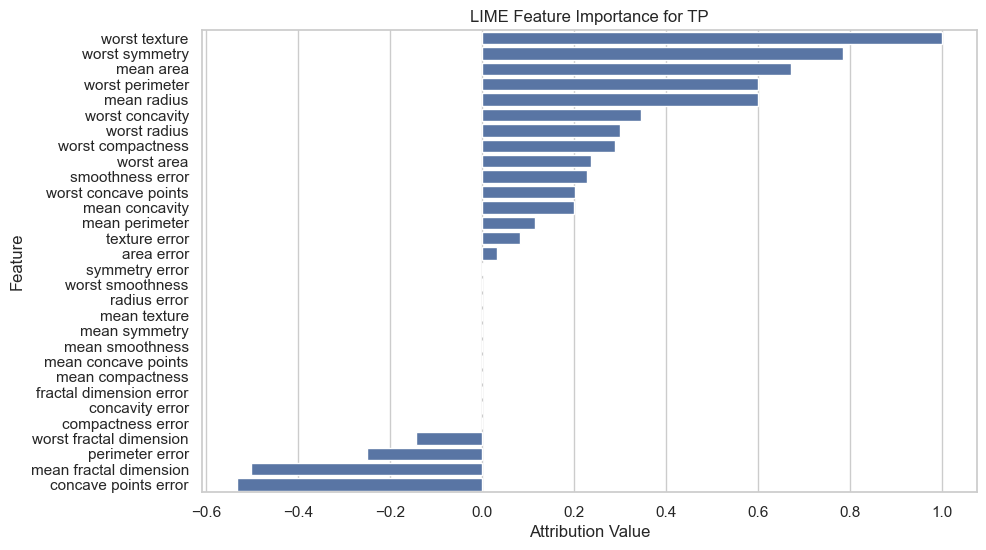

In [16]:
from visualisation.lime import plot_feature_importance


explanations, time = generate_explanations(
    lime, test_data, true_labels, {"TP": selected_indices.get("TP")}
)
print(f"LIME Explanation for TP, time taken : {time} seconds\n")

plot_feature_importance(explanations["TP"]["attributions"], feature_names, "TP")

## **Parsimony**

Parsimony tells us how many features for a given threshold value

In [17]:
from lime_analysis.lime_explanations import parsimony

print(
    f"The parsimony for this instance for a threshold of 0.4 is {parsimony(explanations['TP']['attributions'], threshold=0.1)}"
)

The parsimony for this instance for a threshold of 0.4 is 17


## **Perturbation Steps and Prediction Flips**

### Perturbation Process Overview

We begin with a `TP` class data point and apply perturbations to it. The `perturb_single_instance` function is responsible for managing this process, taking the following inputs:

- **Data Point (Index)**: The index of the selected data point.
- **Explanations**: The generated explanations for the data point.
- **Trained Model**: The machine learning model used for predictions.
- **Dataset**: The test dataset containing all data points.
- **Feature Names**: The list of feature names in the dataset.

#### Perturbation Procedure

1. **Perturb Features**: The function sequentially perturbs the features of the chosen data point. Each feature is replaced by its mean value across the entire dataset.

2. **Track Prediction**: After each perturbation, the model's prediction is recorded. This continues iteratively, starting from:
   - One feature perturbed,
   - Two features perturbed,
   - And so on,
   - Until all features are perturbed.

#### Output and Visualization

The function returns the step at which the model’s prediction flips. 

Using this data, the `plot_perturbation_steps` function generates a plot, visually depicting the number of perturbations that occurred before the model's prediction changed.


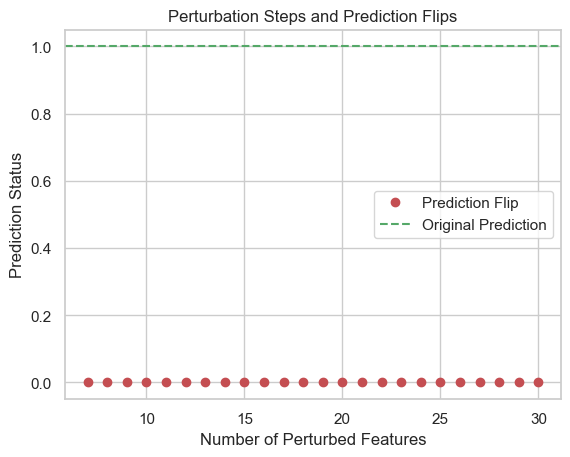

In [18]:
from visualisation.lime import plot_perturbation_steps
from lime_analysis.perturbation import calculate_feature_means, perturb_single_instance

results = perturb_single_instance(
    {"TP": explanations["TP"]["indices"]},
    explanations["TP"]["attributions"],
    model,
    test_data,
    feature_names,
)
plot_perturbation_steps(results)

## **Perturbation Curve for the Entire Dataset**

Next, we examine the **perturbation curve** for the entire dataset. Using the explanations derived from the `TP` class data point, we perturb the features across the entire test dataset and observe how the model’s accuracy is impacted.

#### `perturb_dataset` Function

This function accepts the following inputs:

- **Dataset**: The test dataset to be evaluated.
- **Explanations**: The feature importance scores for the `TP` data point.
- **Trained Model**: The pre-trained machine learning model.
- **Feature Names**: The names of the features within the dataset.

The function operates as follows:

1. **Perturbing Features**: Each feature in the dataset is altered one by one, similar to the perturbation process for a single instance.
2. **Tracking Accuracy**: After each perturbation, the model’s accuracy is recorded.

The function then returns the accuracy values at each perturbation step.

After obtaining the output from the `perturb_dataset` function, further evaluation is performed using the following functions:

- The `plot_perturbation_curve` function generates the **Perturbation Curve** plot, illustrating how the model's accuracy declines as more features are perturbed.
- The `compute_aupc` function calculates the **Area Under the Perturbation Curve (AUPC)**, providing a numerical metric to evaluate the effectiveness of the feature importance explanations.

This process enables a quantitative assessment of how well the feature importance explanations correspond to the model’s decision-making process.


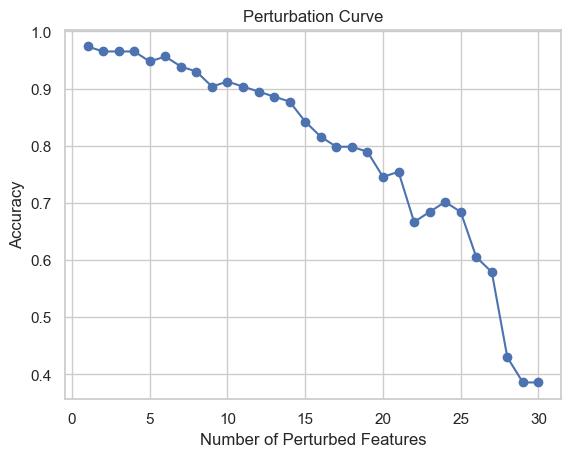

AUPC :23.004386082291603


In [19]:
from visualisation.lime import plot_perturbation_curve
from lime_analysis.perturbation import perturb_dataset, compute_aupc

accuracy_results = perturb_dataset(
    test_data, explanations["TP"]["attributions"], model, feature_names
)
plot_perturbation_curve(accuracy_results)
print(f"AUPC :{compute_aupc(accuracy_results)}")
AUPC_dict["TP"] = compute_aupc(accuracy_results)

<h1><b>2. Analysis for True Negative (TN)</b></h3>


## **Feature Importance Plot and Time Taken**


LIME Explanation for TN, time taken : 0.026031970977783203 seconds



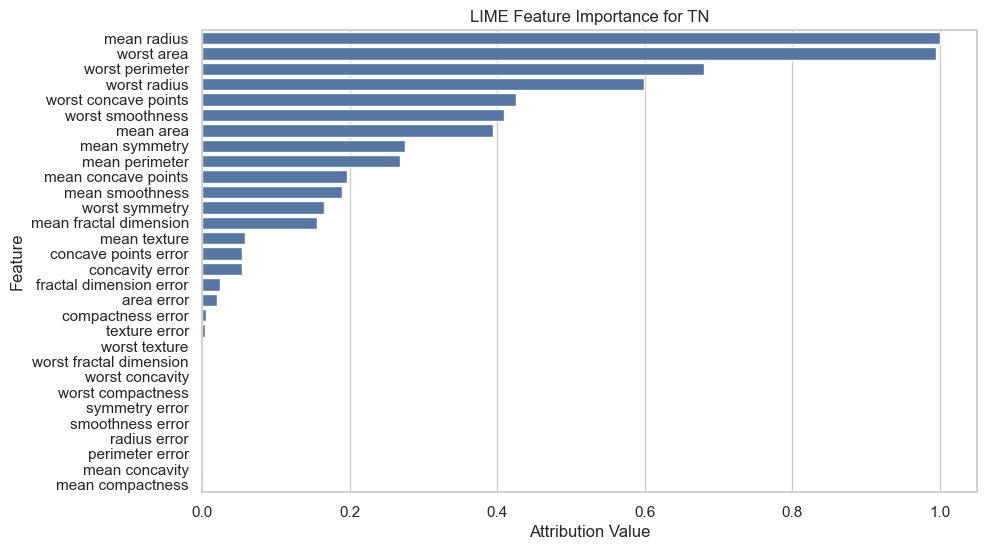

In [20]:
from visualisation.lime import plot_feature_importance


explanations, time = generate_explanations(
    lime, test_data, true_labels, {"TN": selected_indices.get("TN")}
)
print(f"LIME Explanation for TN, time taken : {time} seconds\n")
plot_feature_importance(explanations["TN"]["attributions"], feature_names, "TN")

## **Parsimony**

Parsimony tells us how many features for a given threshold value

In [21]:
from lime_analysis.lime_explanations import parsimony

print(
    f"The parsimony for this instance for a threshold of 0.4 is {parsimony(explanations['TN']['attributions'], threshold=0.1)}"
)

The parsimony for this instance for a threshold of 0.4 is 13


## **Perturbation Steps and Prediction Flips**

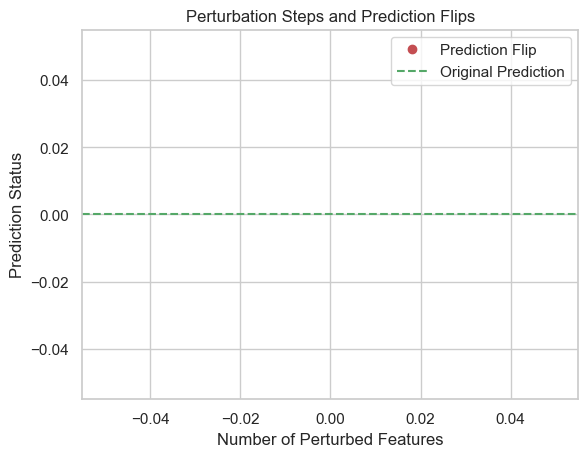

In [22]:
from visualisation.lime import plot_perturbation_steps
from lime_analysis.perturbation import calculate_feature_means, perturb_single_instance

results = perturb_single_instance(
    {"TN": explanations["TN"]["indices"]},
    explanations["TN"]["attributions"],
    model,
    test_data,
    feature_names,
)
plot_perturbation_steps(results)

## **Perturbation Curve for the Entire Dataset**

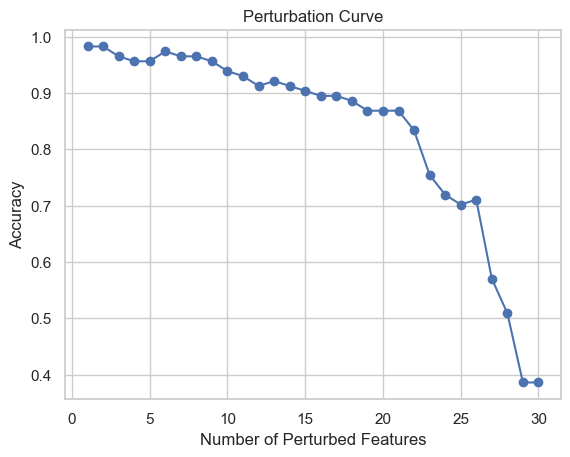

AUPC :24.385964885354042


In [23]:
from visualisation.lime import plot_perturbation_curve
from lime_analysis.perturbation import perturb_dataset, compute_aupc

accuracy_results = perturb_dataset(
    test_data, explanations["TN"]["attributions"], model, feature_names
)
plot_perturbation_curve(accuracy_results)
print(f"AUPC :{compute_aupc(accuracy_results)}")
AUPC_dict["TN"] = compute_aupc(accuracy_results)


<h1 ><b>3. Analysis for False Positive (FP)</b></h3>


## **Feature Importance Plot and Time Taken**


LIME Explanation for FP, time taken : 0.027086734771728516 seconds



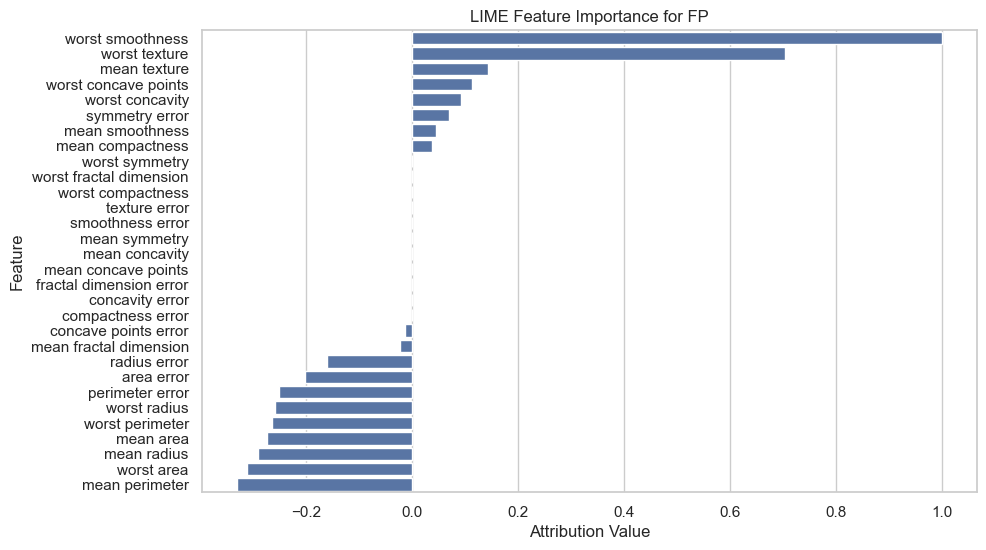

In [24]:
from visualisation.lime import plot_feature_importance


explanations, time = generate_explanations(
    lime, test_data, true_labels, {"FP": selected_indices.get("FP")}
)
print(f"LIME Explanation for FP, time taken : {time} seconds\n")
plot_feature_importance(explanations["FP"]["attributions"], feature_names, "FP")

## **Parsimony**

Parsimony tells us how many features for a given threshold value

In [25]:
from lime_analysis.lime_explanations import parsimony

print(
    f"The parsimony for this instance for a threshold of 0.4 is {parsimony(explanations['FP']['attributions'], threshold=0.1)}"
)

The parsimony for this instance for a threshold of 0.4 is 13


## **Perturbation Steps and Prediction Flips**

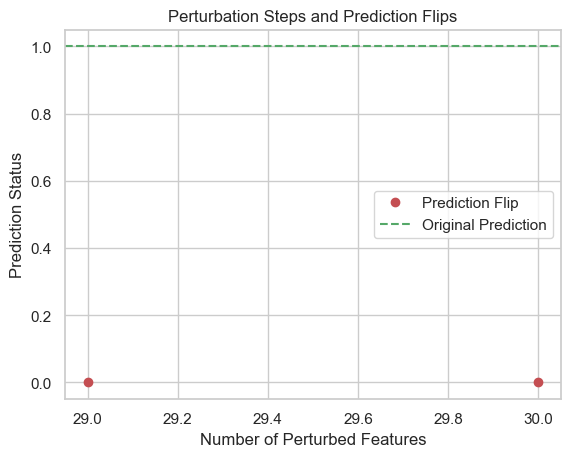

In [26]:
from visualisation.lime import plot_perturbation_steps
from lime_analysis.perturbation import calculate_feature_means, perturb_single_instance

results = perturb_single_instance(
    {"FP": explanations["FP"]["indices"]},
    explanations["FP"]["attributions"],
    model,
    test_data,
    feature_names,
)
plot_perturbation_steps(results)

## **Perturbation Curve for the Entire Dataset**

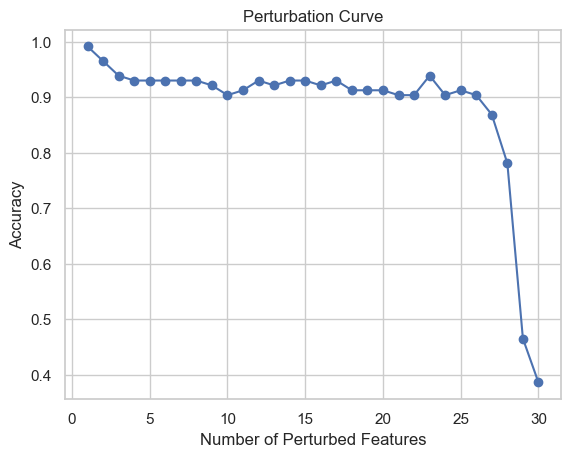

AUPC :25.855263397097588


In [27]:
from visualisation.lime import plot_perturbation_curve
from lime_analysis.perturbation import perturb_dataset, compute_aupc

accuracy_results = perturb_dataset(
    test_data, explanations["FP"]["attributions"], model, feature_names
)
plot_perturbation_curve(accuracy_results)
print(f"AUPC :{compute_aupc(accuracy_results)}")
AUPC_dict["FP"] = compute_aupc(accuracy_results)


<h1 ><b>4. Analysis for False Negative (FN)</b></h3>


## **Feature Importance Plot and Time Taken**


LIME Explanation for FN, time taken : 0.0285341739654541 seconds



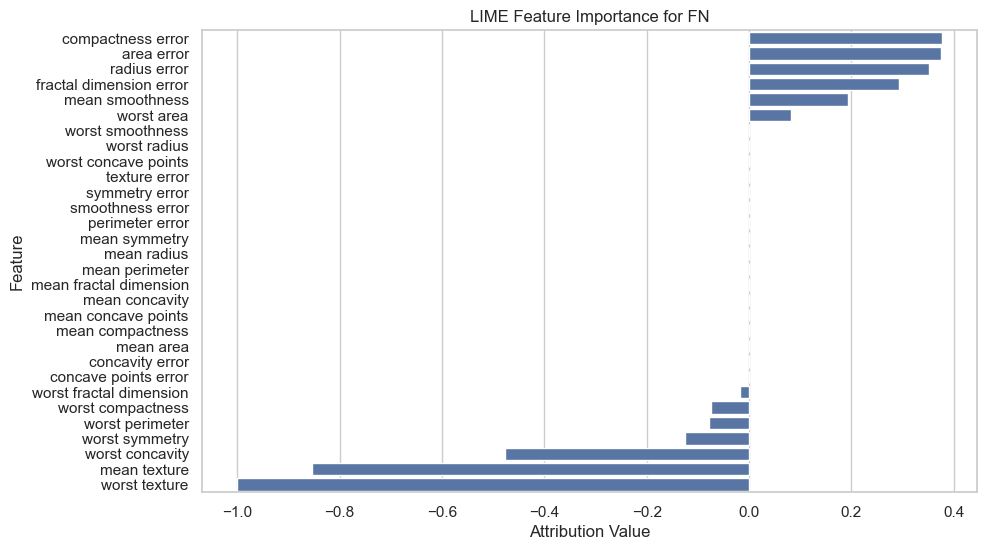

In [28]:
from visualisation.lime import plot_feature_importance


explanations, time = generate_explanations(
    lime, test_data, true_labels, {"FN": selected_indices.get("FN")}
)
print(f"LIME Explanation for FN, time taken : {time} seconds\n")
plot_feature_importance(explanations["FN"]["attributions"], feature_names, "FN")

## **Parsimony**

Parsimony tells us how many features for a given threshold value

In [29]:
from lime_analysis.lime_explanations import parsimony

print(
    f"The parsimony for this instance for a threshold of 0.4 is {parsimony(explanations['FN']['attributions'], threshold=0.1)}"
)

The parsimony for this instance for a threshold of 0.4 is 9


## **Perturbation Steps and Prediction Flips**

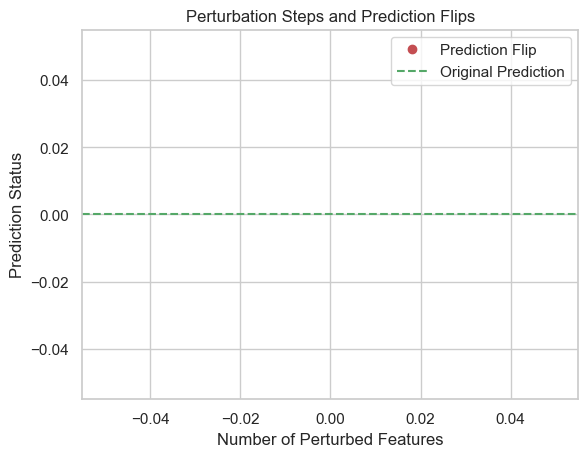

In [30]:
from visualisation.lime import plot_perturbation_steps
from lime_analysis.perturbation import calculate_feature_means, perturb_single_instance

results = perturb_single_instance(
    {"FN": explanations["FN"]["indices"]},
    explanations["FN"]["attributions"],
    model,
    test_data,
    feature_names,
)

plot_perturbation_steps(results)

## **Perturbation Curve for the Entire Dataset**

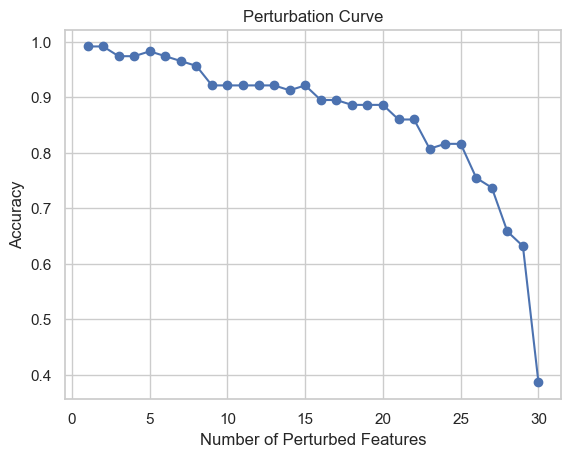

AUPC :25.328947231173515


In [31]:
from visualisation.lime import plot_perturbation_curve
from lime_analysis.perturbation import perturb_dataset, compute_aupc

accuracy_results = perturb_dataset(
    test_data, explanations["FN"]["attributions"], model, feature_names
)
plot_perturbation_curve(accuracy_results)
print(f"AUPC :{compute_aupc(accuracy_results)}")
AUPC_dict["FN"] = compute_aupc(accuracy_results)

## **Comparing AUPC of Different Samples**

The `visualize_aupc` function allows us to visualize the various AUPCs calculated for different samples, providing insights into which sample’s explanation has the most significant impact on the model. A lower AUPC score indicates a greater impact. The function accepts a dictionary-like object that maps category names to their corresponding AUPC scores.


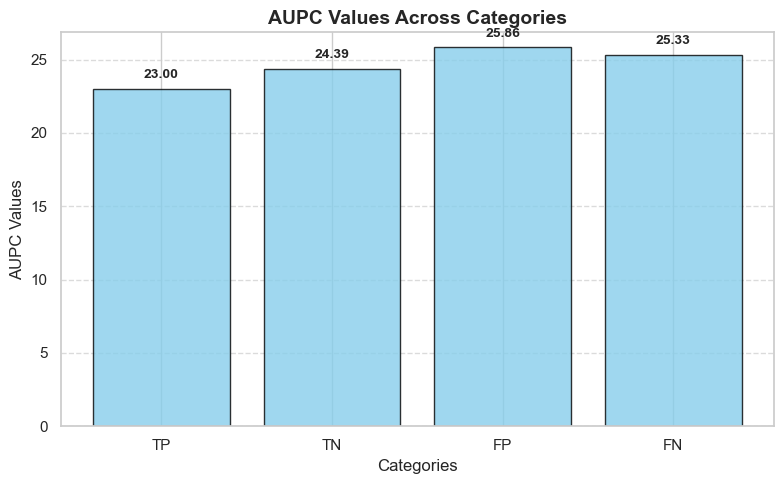

In [32]:
from visualisation.lime import visualize_aupc

visualize_aupc(
    aupc_dict=AUPC_dict,
)